In [55]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil

from keras.callbacks import Callback

class ProgressTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: loss={:.4f}, accuracy={:.4f}".format(epoch+1, logs['loss'], logs['accuracy']))



In [56]:

def cleanDataAndNormalize(X, y): 
    classNames = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Usando máscara para remover imagens desconhecidas ou NF
    y_mask = y.argmax(axis=-1)
    mask = y_mask < classNames.index('unknown')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y



In [57]:

def splitData(X, y):
    test_size = ceil(len(X) * 0.1)

    # Dividindo o dataset em Train e Test
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size)

    return x_train, y_train, x_val, y_val, x_test, y_test


In [58]:


def dataAugmentation(x_train): # Data augmentation para balancear o dataset
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen


In [59]:


def showAugmentedImages(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
        plt.xlabel(class_names[y_train[i]])
    plt.show()

In [60]:

def preProcessData():
    data = pd.read_csv('../data/fer2013.csv')
    labels = pd.read_csv('../data/fer2013new.csv')

    classNames = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    nSamples = len(data)
    w = 48
    h = 48

    y = np.array(labels[classNames])
    X = np.zeros((nSamples, w, h, 1))
    for i in range(nSamples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y


In [61]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
def defineModel(input_shape=(48, 48, 3), classes=7):
    # base_model = ResNet50(include_top=False, input_shape=input_shape)
    vgg = vgg16.VGG16(include_top=False, weights=None, input_shape=(48, 48, 1))

    x = vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)
    
    model = Model(inputs=vgg.input, outputs=predictions)

    return model

# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.models import Model

# def define_model(input_shape=(48, 48, 3), classes=7):
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

#     x = base_model.output
#     x = Flatten()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dense(512, activation='relu')(x)
#     predictions = Dense(classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)
    
#     # Freeze the layers of the base model
#     for layer in base_model.layers:
#         layer.trainable = False

#     return model


In [62]:

def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0, 3.5])
    plt.legend(loc='upper right')
    plt.show()


def save_model_and_weights(model, test_acc):
    # Serialize and save model to JSON
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
    with open('Saved-Models\\model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Serialize and save weights to JSON
    model.save_weights('Saved-Models\\modelYOLO' + str(test_acc) + '.h5')
    print('Model and weights are saved in separate files.')


def load_model_and_weights(model_path, weights_path):
    # Loading JSON model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # Loading weights
    model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Model and weights are loaded and compiled.')


In [63]:

def runModel():
    fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

    X, y = preProcessData()
    X, y = cleanDataAndNormalize(X, y)
    x_train, y_train, x_val, y_val, x_test, y_test = splitData(X, y)
    datagen = dataAugmentation(x_train)

    epochs = 85
    batch_size = 64

    print("X_train shape: " + str(x_train.shape))
    print("Y_train shape: " + str(y_train.shape))
    print("X_test shape: " + str(x_test.shape))
    print("Y_test shape: " + str(y_test.shape))
    print("X_val shape: " + str(x_val.shape))
    print("Y_val shape: " + str(y_val.shape))

    # Training model from scratch

    model = defineModel(input_shape=x_train[0].shape, classes=len(fer_classes))
    model.summary()
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[ProgressTracker()]
                        , verbose=2)
    

# 
    # model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    # showAugmentedImages(datagen, x_train)
    plot_acc_loss(history)
    save_model_and_weights(model, test_acc)



X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D

/opt/homebrew/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/85
Epoch 1: loss=0.3596, accuracy=0.3715
443/443 - 690s - loss: 0.3596 - accuracy: 0.3715 - val_loss: 0.3507 - val_accuracy: 0.3759 - 690s/epoch - 2s/step
Epoch 2/85
Epoch 2: loss=0.3473, accuracy=0.3860
443/443 - 752s - loss: 0.3473 - accuracy: 0.3860 - val_loss: 0.3417 - val_accuracy: 0.4134 - 752s/epoch - 2s/step
Epoch 3/85
Epoch 3: loss=0.3304, accuracy=0.4604
443/443 - 751s - loss: 0.3304 - accuracy: 0.4604 - val_loss: 0.3013 - val_accuracy: 0.5602 - 751s/epoch - 2s/step
Epoch 4/85
Epoch 4: loss=0.2871, accuracy=0.5922
443/443 - 756s - loss: 0.2871 - accuracy: 0.5922 - val_loss: 0.2709 - val_accuracy: 0.6247 - 756s/epoch - 2s/step
Epoch 5/85
Epoch 5: loss=0.2609, accuracy=0.6511
443/443 - 751s - loss: 0.2609 - accuracy: 0.6511 - val_loss: 0.2439 - val_accuracy: 0.6889 - 751s/epoch - 2s/step
Epoch 6/85
Epoch 6: loss=0.2452, accuracy=0.6856
443/443 - 743s - loss: 0.2452 - accuracy: 0.6856 - val_loss: 0.2384 - val_accuracy: 0.6988 - 743s/epoch - 2s/step
Epoch 7/85
Epoch 7: lo

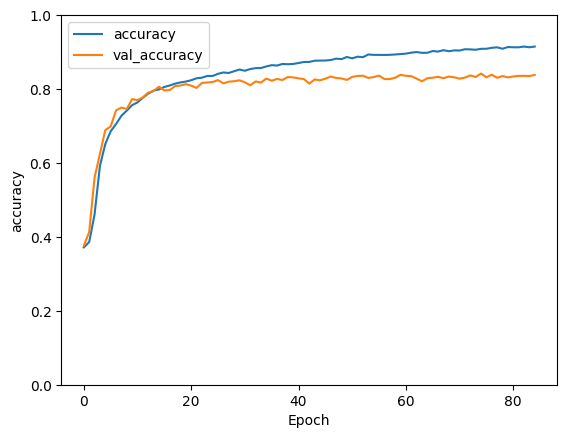

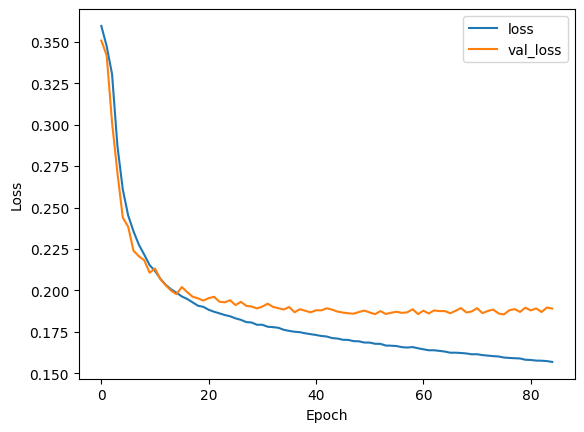

Model and weights are saved in separate files.


: 

In [64]:
runModel()